In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = "../DATA/data/Train_0704/" 
file_list = os.listdir(data_path)
data_list = []

for file in file_list:
    if file.endswith(".csv"):
        code_name = file.split("_")[1].split(".")[0]
        file_path = os.path.join(data_path, file)
        temp_data = pd.read_csv(file_path)

        # 품목번호를 추가
        temp_data['품목번호'] = code_name

        # temp_data를 data_list에 추가
        data_list.append(temp_data)

# data_list의 모든 DataFrame을 연결하여 하나의 DataFrame으로 합치기
data = pd.concat(data_list, ignore_index=True)

# 원래의 '품목번호' 값을 보존
data['original_품목번호'] = data['품목번호'].copy()

# 품목번호와 요일을 원-핫 인코딩으로 변환
data = pd.get_dummies(data, columns=['품목번호', '요일'])

# 날짜를 Datetime 형식으로 변환하고 인덱스로 설정
data['datadate'] = pd.to_datetime(data['datadate'], format='%Y%m%d')
data.set_index('datadate', inplace=True)

# data_features = data.columns
# 피처 선택
data_features = data.columns.drop([
                            #  '총거래대금_mMG',
                            #  '하위가격 평균가(원)_mMG', 
                            #  '상위가격 평균가(원)_mMG',
                            #  '일자별_도매가격_최대(원)_mMG',
                            #  '일자별_도매가격_최소(원)_mMG',
                            #  '일자별_도매가격_평균(원)_mMG', 
                            #  '일자별_소매가격_최대(원)_mMG',
                            #  '일자별_소매가격_최소(원)_mMG',
                            #  '일자별_소매가격_평균(원)_mMG',
                            #  '하위가격 거래물량(kg)_ROC', 
                            #  '상위가격 거래물량(kg)_ROC',
                            #  '하위가격 평균가(원)_ROC', 
                            #  '상위가격 평균가(원)_ROC',
                            #  '일자별_도매가격_최대(원)_ROC',
                            #  '일자별_도매가격_최소(원)_ROC', 
                            #  '일자별_도매가격_평균(원)_ROC',
                            #  '일자별_소매가격_최대(원)_ROC',
                            #  '일자별_소매가격_최소(원)_ROC',
                            #  '일자별_소매가격_평균(원)_ROC',
                            #  '하위가격 거래물량(kg)_mMG', 
                            #  '상위가격 거래물량(kg)_mMG',
                            #  '총거래대금_ROC',
                             
        ])

# 해당날짜 feature dataframe
data_atday = data[data_features]

# 컬럼명 저장
data_col_list = data.columns.tolist()
pd.Series(data_col_list).to_csv('data_col.csv')
data_atday_col_list = data_atday.columns.tolist()
pd.Series(data_atday_col_list).to_csv('data_atday_col.csv')

In [10]:
# 입력 데이터에 대한 14일 동안의 lag 피처를 추가
def create_lag_features(df_atday, lag_columns, lag_days):
    lag_df = df_atday.copy()
    
    lag_frames = []
    for column in lag_columns:
        for i in range(1, lag_days + 1):
            lag_col = pd.DataFrame(df_atday[column].shift(i))
            lag_col.columns = [f'{column}_lag_{i}']
            lag_frames.append(lag_col)
    
    lag_df = pd.concat([lag_df] + lag_frames, axis=1)
    return lag_df

# Use your desired set of features to lag
lag_features = data_atday.columns.drop(['해당일자_전체거래물량', '해당일자_평균가격', 'original_품목번호',
                                        '일자구분_중순', '일자구분_초순', '일자구분_하순',
                                        '월구분_1월', '월구분_2월', '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', 
                                        '월구분_7월', '월구분_8월', '월구분_9월', '월구분_10월', '월구분_11월', '월구분_12월', 
                                        '경락거래없는날', '도매거래없는날', '소매거래없는날', '연중주차', '연중일차', '분기', '월중일자',
                                        '품목번호_1', '품목번호_10', '품목번호_11', '품목번호_12', '품목번호_13', '품목번호_15',
                                        '품목번호_16', '품목번호_17', '품목번호_18', '품목번호_2', '품목번호_20', '품목번호_21',
                                        '품목번호_22', '품목번호_23', '품목번호_24', '품목번호_25', '품목번호_26', '품목번호_27',
                                        '품목번호_28', '품목번호_29', '품목번호_3', '품목번호_4', '품목번호_5', '품목번호_6', 
                                        '품목번호_7',
                                        '품목번호_14', '품목번호_19', 
                                        '품목번호_8', '품목번호_9', 
                                        '요일_금', '요일_목', '요일_수', '요일_월', '요일_일', '요일_토', '요일_화'
                                        ])  
lag_days = 14
data_lag = create_lag_features(data_atday, lag_features, lag_days)

# 이전데이터만 이용하기 위해 atday(해당날짜) feature column 제거
lag_df_features = data_lag.columns
lag_df_features = lag_df_features.drop(lag_features)
data_lag = data_lag[lag_df_features].fillna(method='ffill')

data_lag_col_list = data_lag.columns.tolist()
data_lag_col_list
pd.Series(data_lag_col_list).to_csv('data_lag_col.csv')
data.head(100).to_csv('data.csv')
data_lag.head(100).to_csv('data_lag.csv')

In [11]:
train_data = data_lag.loc['2017-01-15':'2022-12-31']
test_data = data_lag.loc['2023-01-02':'2023-05-10']

In [12]:
# 피처 선택
features = data_lag.columns.drop(['해당일자_전체거래물량', '해당일자_평균가격', 'original_품목번호'])

model_trade_volume = LGBMRegressor()
model_avg_price = LGBMRegressor()

X_train = train_data[features]
y_train_trade_volume = train_data['해당일자_전체거래물량']
y_train_avg_price = train_data['해당일자_평균가격']

model_trade_volume.fit(X_train, y_train_trade_volume)
model_avg_price.fit(X_train, y_train_avg_price)

X_test = test_data[features]

y_pred_trade_volume = model_trade_volume.predict(X_test)
y_pred_avg_price = model_avg_price.predict(X_test)
y_pred_trade_volume = pd.Series(y_pred_trade_volume).fillna(method='ffill').to_numpy()
test_data['해당일자_전체거래물량'] = test_data['해당일자_전체거래물량'].fillna(method='ffill')
y_pred_avg_price = pd.Series(y_pred_avg_price).fillna(0).to_numpy()
test_data['해당일자_평균가격'] = test_data['해당일자_평균가격'].fillna(method='ffill')

mse_trade_volume = mean_absolute_error(test_data['해당일자_전체거래물량'], y_pred_trade_volume)
mse_avg_price = mean_absolute_error(test_data['해당일자_평균가격'], y_pred_avg_price)

print("MAE for 전체거래물량:", mse_trade_volume)
print("MAE for 평균가격:", mse_avg_price)

test_data['예측_해당일자_전체거래물량'] = y_pred_trade_volume
test_data['예측_해당일자_평균가격'] = y_pred_avg_price
print(test_data[['original_품목번호','해당일자_전체거래물량','예측_해당일자_전체거래물량', '해당일자_평균가격','예측_해당일자_평균가격']])


MAE for 전체거래물량: 19177.866264940654
MAE for 평균가격: 311.9447169674686
           original_품목번호  해당일자_전체거래물량  예측_해당일자_전체거래물량  해당일자_평균가격  예측_해당일자_평균가격
datadate                                                                      
2023-01-02             4      25180.0    29190.405674     1711.0   1634.636959
2023-01-03             4      66879.0    36123.613213     1746.0   1688.804508
2023-01-04             4      67350.0    57303.571609     1686.0   1720.762124
2023-01-05             4      44360.0    56771.699219     1579.0   1582.362155
2023-01-06             4      56840.0    43026.552438     1802.0   1573.249083
...                  ...          ...             ...        ...           ...
2023-05-06             9      54950.0    50468.500944     2380.0   3226.211848
2023-05-07             9      54950.0    51459.107690     2380.0   2721.732129
2023-05-08             9      66948.0    60853.204463     2437.0   2760.007707
2023-05-09             9      48417.5    48884.754425     1740.0

In [7]:
test_data['예측_해당일자_전체거래물량_shifted'] = test_data['예측_해당일자_전체거래물량'].shift(0)
test_data['예측_해당일자_평균가격_shifted'] = test_data['예측_해당일자_평균가격'].shift(-1)

nrow_test = test_data.shape[0] - 1
mse_trade_volume_shifted = mean_absolute_error(test_data['예측_해당일자_전체거래물량_shifted'][:nrow_test], test_data['해당일자_전체거래물량'][:nrow_test])
mse_avg_price_shifted = mean_absolute_error(test_data['예측_해당일자_평균가격_shifted'][:nrow_test], test_data['해당일자_평균가격'][:nrow_test])

print("MAE for 전체거래물량:", mse_trade_volume_shifted)
print("MAE for 평균가격:", mse_avg_price_shifted)

MAE for 전체거래물량: 19302.91612587716
MAE for 평균가격: 233.23572205381194


In [ ]:
# 경락거래 없는 날 제외
test_notrade = test_data[test_data['경락거래없는날']==0]
X_test_notrade = X_test[X_test['경락거래없는날']==0]

y_pred_trade_volume_notrade = model_trade_volume.predict(X_test_notrade)
y_pred_avg_price_notrade = model_avg_price.predict(X_test_notrade)
y_pred_trade_volume_notrade = pd.Series(y_pred_trade_volume_notrade).fillna(method='ffill').to_numpy()
test_notrade['해당일자_전체거래물량'] = test_notrade['해당일자_전체거래물량'].fillna(method='ffill')
y_pred_avg_price_notrade = pd.Series(y_pred_avg_price_notrade).fillna(method='ffill').to_numpy()
test_notrade['해당일자_평균가격'] = test_notrade['해당일자_평균가격'].fillna(method='ffill')

mse_trade_volume_notrade = mean_absolute_error(test_notrade['해당일자_전체거래물량'], y_pred_trade_volume_notrade)
mse_avg_price_notrade = mean_absolute_error(test_notrade['해당일자_평균가격'], y_pred_avg_price_notrade)

print("MAE for 전체거래물량:", mse_trade_volume_notrade)
print("MAE for 평균가격:", mse_avg_price_notrade)

test_notrade['예측_해당일자_전체거래물량'] = y_pred_trade_volume_notrade
test_notrade['예측_해당일자_평균가격'] = y_pred_avg_price_notrade
print(test_notrade[['original_품목번호','해당일자_전체거래물량','예측_해당일자_전체거래물량', '해당일자_평균가격','예측_해당일자_평균가격']])

In [ ]:
test_data_notrade = test_data[test_data['경락거래없는날']==0]

mse_trade_volume_notrade = mean_absolute_error(test_data_notrade['해당일자_전체거래물량'], test_data_notrade['예측_해당일자_전체거래물량'])
mse_avg_price_notrade = mean_absolute_error(test_data_notrade['해당일자_평균가격'][:-1], test_data_notrade['예측_해당일자_평균가격_shifted'][:-1])

print("MAE for 전체거래물량_notrade:", mse_trade_volume_notrade)
print("MAE for 평균가격_notrade:", mse_avg_price_notrade)

# test_data_notrade['예측_해당일자_전체거래물량'] = y_pred_trade_volume_notrade
# test_data_notrade['예측_해당일자_평균가격'] = y_pred_avg_price_notrade
print(test_data_notrade[['original_품목번호','해당일자_전체거래물량','예측_해당일자_전체거래물량', '해당일자_평균가격','예측_해당일자_평균가격_shifted', '예측_해당일자_평균가격','경락거래없는날']])

In [10]:
# 원래의 '품목번호' 값을 보존
result_data = test_data[['original_품목번호', '해당일자_전체거래물량','예측_해당일자_전체거래물량', '해당일자_평균가격','예측_해당일자_평균가격_shifted','예측_해당일자_평균가격','경락거래없는날']]
result_data.to_csv('0712_lgbm_result_lag.csv')
test_data.head(50).to_csv('0712_result_test.csv')

In [11]:
def get_feature_importance_df(model, features):
    # split을 기준으로 importance를 구할 때 
    feature_importance = model.feature_importances_

    # # gain을 기준으로 importance를 구할 때 
    # booster = model.booster_ # 모델의 booster 객체를 가져옵니다.
    # feature_importance = booster.feature_importance(importance_type='gain') # booster.feature_importance를 사용하여 각 importance type에 따라 중요도를 얻습니다.
    
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    })
    sorted_feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    return sorted_feature_importance_df

# 두 모델 model_trade_volume 및 model_avg_price에 대한 feature importance
trade_volume_feature_importance = get_feature_importance_df(model_trade_volume, features)
avg_price_feature_importance = get_feature_importance_df(model_avg_price, features)

print('Feature importance for trade volume prediction:')
print(trade_volume_feature_importance)
print('\nFeature importance for average price prediction:')
print(avg_price_feature_importance)

Feature importance for trade volume prediction:
                        feature  importance
178         상위가격 거래물량(kg)_lag_1         108
148         하위가격 거래물량(kg)_lag_1         106
54                         요일_월         102
184         상위가격 거래물량(kg)_lag_7          63
16                      도매거래없는날          54
...                         ...         ...
529                 무역수지_lag_22           0
530                 무역수지_lag_23           0
531                 무역수지_lag_24           0
532                 무역수지_lag_25           0
1557  일자별_소매가격_최소(원)_ROC_lag_30           0

[1558 rows x 2 columns]

Feature importance for average price prediction:
                    feature  importance
118       상위가격 평균가(원)_lag_1         174
1030   해당일자_평균가격_mMG_lag_13         127
88        하위가격 평균가(원)_lag_1          97
1018    해당일자_평균가격_mMG_lag_1          63
15                  경락거래없는날          50
...                     ...         ...
1040   해당일자_평균가격_mMG_lag_23           0
385   일자별_소매가격_최소(원)_lag_28  

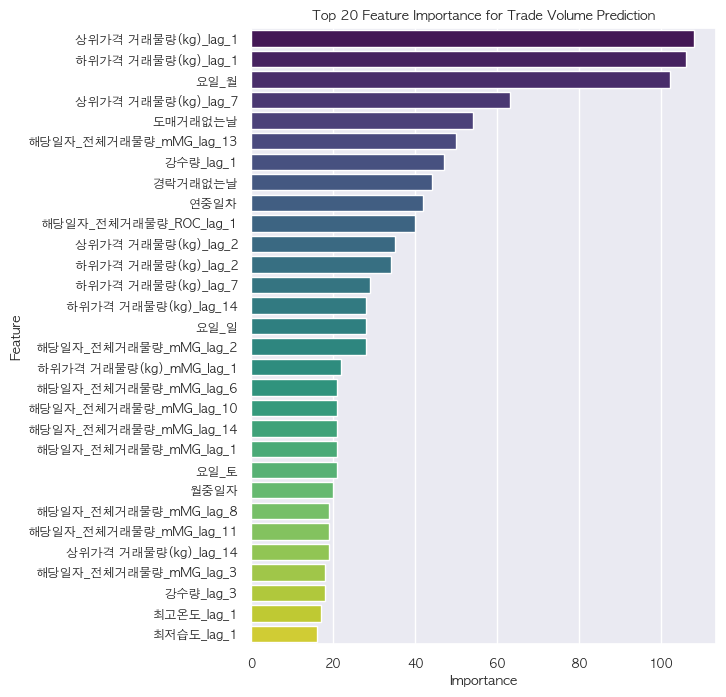

<Figure size 640x480 with 0 Axes>

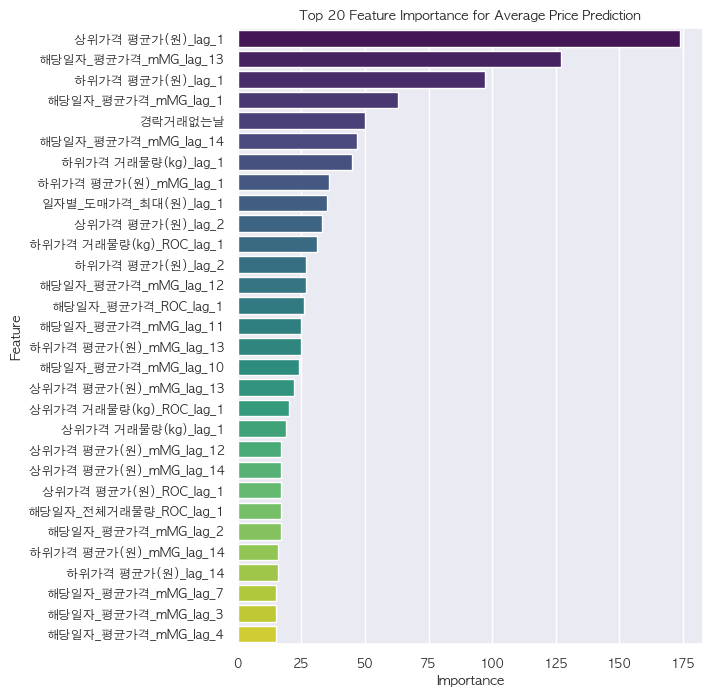

<Figure size 640x480 with 0 Axes>

In [18]:
def plot_top_n_feature_importance(df, title, top_n=30):
    # 상위 top_n개의 특성만 선택
    df = df.head(top_n)

    plt.figure(figsize=(6, 8))
    plt.rc('font', family='AppleGothic')
    plt.rc('axes', unicode_minus=False)
    sns.barplot(data=df, x='importance', y='feature', palette='viridis')
    plt.title(title)
    sns.set(font_scale=0.8)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    plt.clf()
# 두 모델 model_trade_volume 및 model_avg_price에 대한 feature importance 그래프
plot_top_n_feature_importance(trade_volume_feature_importance, 'Top 20 Feature Importance for Trade Volume Prediction')
plot_top_n_feature_importance(avg_price_feature_importance, 'Top 20 Feature Importance for Average Price Prediction')


In [81]:
import matplotlib.pyplot as plt
# plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
# plt.rc('xtick', labelsize=50)  # x축 눈금 폰트 크기 
# plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
# plt.rc('legend', fontsize=20)  # 범례 폰트 크기
# plt.rc('figure', titlesize=50) 

def plot_and_save(item_number, test_data):
    filtered_data = test_data[test_data['original_품목번호'] == str(item_number)]
    filtered_nrow = filtered_data.shape[0]

    df = pd.DataFrame(filtered_data)
    x_values = range(filtered_nrow)

    plt.figure(figsize=(6, 3))
    plt.plot(df['해당일자_전체거래물량'][:filtered_nrow], label='Actual')
    plt.plot(df['예측_해당일자_전체거래물량'][:filtered_nrow], label='Predicted')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Total Transaction Volume')
    plt.title(f'Actual vs Predicted Total Transaction Volume for Item {item_number}')
    plt.xticks(rotation=45)
    plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize=10)  # 범례 폰트 크기
    # plt.rc('figure', titlesize=50) # figure title 폰트 크기  
    
    # 그래프를 파일로 저장
    plt.savefig(f'plot/plot_item_{item_number}.png', bbox_inches='tight')
    plt.clf()

for i in range(1, 30):
    plot_and_save(i, test_data)


/var/folders/7d/d1khjvv95fs1dx3zplr2sfzh0000gn/T/ipykernel_6117/3862175169.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 3))


<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [82]:
def plot_and_save(item_number, test_data):
    filtered_data = test_data[test_data['original_품목번호'] == str(item_number)]
    filtered_nrow = filtered_data.shape[0] - 1

    df = pd.DataFrame(filtered_data)

    plt.figure(figsize=(6, 3))
    plt.plot(df['해당일자_평균가격'][:filtered_nrow], label='Actual')
    plt.plot(df['예측_해당일자_평균가격_shifted'][:filtered_nrow], label='Predicted')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Actual vs Predicted Price for Item {item_number}')
    plt.xticks(rotation=45)
    plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize=10)  # 범례 폰트 크기
    # plt.rc('figure', titlesize=50) # figure title 폰트 크기  
    
    # 그래프를 파일로 저장
    plt.savefig(f'plot/plot_item_{item_number}_price.png', bbox_inches='tight')
    plt.clf()

for i in range(1, 30):
    plot_and_save(i, test_data)

/var/folders/7d/d1khjvv95fs1dx3zplr2sfzh0000gn/T/ipykernel_6117/3710455732.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 3))


<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>